### Master of Applied Artificial Intelligence

**Course: TC4033 - Autonomous Driving**

<img src="./../images/logo.png" alt="TEC DE MONTERREY" width="500"/>

**PEDESTRIAN DETECTION WITH HOG AND SVM**

Tutor: Dr. David Antonio Torres


Team members:
* Rafael Bernando Orozco Palma - A01795359
* Arantxa Stephania Coronel González - A01620352
* Alejandro Calderon Aguilar - A01795353

# Import libraries

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from skimage.feature import hog
import glob
import os
import sys
import pandas as pd

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

sys.path.append(os.path.abspath(".."))


from src.pedestrians.pedestrians import Pedestrians
from src.utils.utils import Utils


# Global variables

In [2]:
notebook_dir = os.getcwd()
base_dir = os.path.abspath(os.path.join(os.path.dirname(notebook_dir), "data"))
train_processed_pedestrians_path = base_dir + "/pedestrians/processed/train/"
train_raw_pedestrians_path = base_dir + "/pedestrians/raw/train/"
nrows = 5
ncols = 2
figsize=(12, 18)

# Import pedestrian dataset
### https://www.kaggle.com/datasets/karthika95/pedestrian-detection?resource=download

In [3]:
train_pedestrians = Pedestrians(processed_path=train_processed_pedestrians_path, raw_path=train_raw_pedestrians_path)

/Users/alejandrocalderon/Documents/MIA/self_driving_car/data/pedestrians/raw/train/pedestrians_dataset.csv
Pedestrians dataset generated


In [4]:
utils = Utils(raw_path=train_raw_pedestrians_path, processed_path=train_processed_pedestrians_path)

# Load pedestrian Dataset

In [5]:
pedestrians_df = pd.read_csv(train_pedestrians.dataset_name)
pedestrians_df.head()

,filename,label
0,/Users/alejandrocalderon/Documents/MIA/self_dr...,1
1,/Users/alejandrocalderon/Documents/MIA/self_dr...,1
2,/Users/alejandrocalderon/Documents/MIA/self_dr...,1
3,/Users/alejandrocalderon/Documents/MIA/self_dr...,1
4,/Users/alejandrocalderon/Documents/MIA/self_dr...,1


# Get dataset description

In [6]:
# How many images are in the dataset
pedestrians_df.count()

filename    2066
label       2066
dtype: int64

In [7]:
# Identify how many possible classes are in the dataset to classify
pedestrians_df["label"].value_counts()

label
1    1106
0     960
Name: count, dtype: int64

# Show a sample of pedestrian images

In [8]:
# sample of 10 rows
random_pedestrians = pedestrians_df.sample(n=10)
# show the 5 rows
random_pedestrians.head()

,filename,label
88,/Users/alejandrocalderon/Documents/MIA/self_dr...,1
1584,/Users/alejandrocalderon/Documents/MIA/self_dr...,0
1242,/Users/alejandrocalderon/Documents/MIA/self_dr...,0
402,/Users/alejandrocalderon/Documents/MIA/self_dr...,1
1762,/Users/alejandrocalderon/Documents/MIA/self_dr...,0


In [9]:
# get the file path image of sample
tmp_pedestrian_path_imgs= random_pedestrians.get("filename").to_list()
# a variable to specify if the image is a pedestrian or not
tmp_pedestrian_labels = random_pedestrians.get("label").apply(lambda x: "Pedestrian" if x == 1 else "Not pedestrian").to_list()

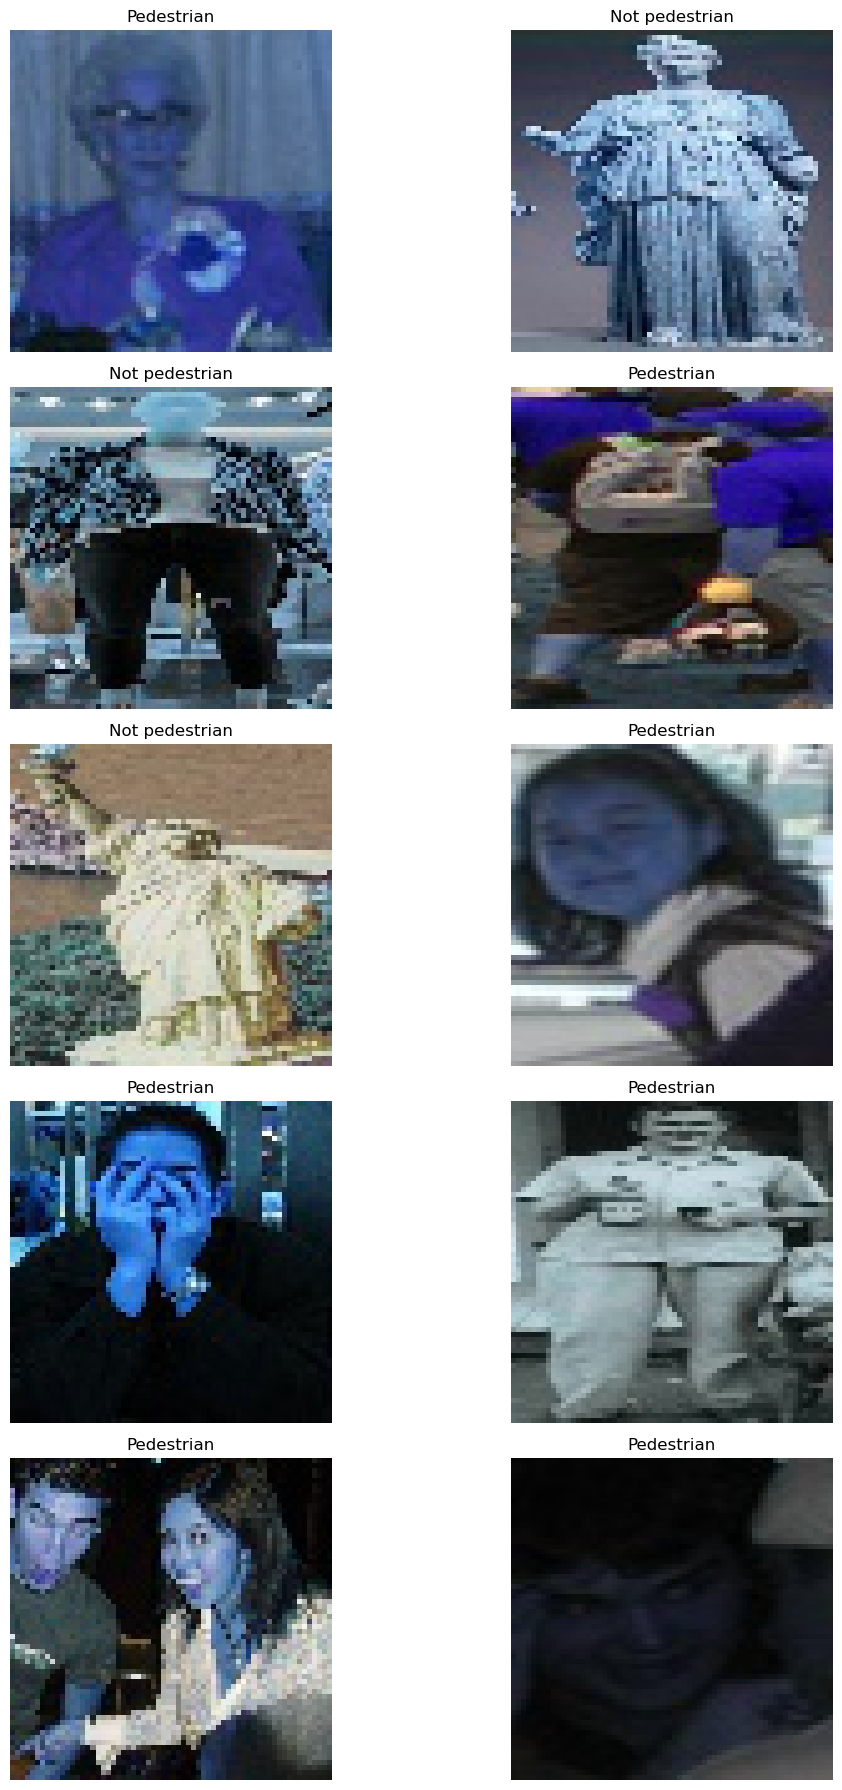

In [10]:
# with utils read_images method, get an array of images gotten in sample dataset
tmp_pedestrian_imgs = utils.read_images(path_images=tmp_pedestrian_path_imgs)
# with utils plot_images method, plot the images gotten in sample dataset
utils.plot_images(images=tmp_pedestrian_imgs, labels=tmp_pedestrian_labels, nrows=nrows, ncols=ncols, figsize=figsize)

# HOG Image

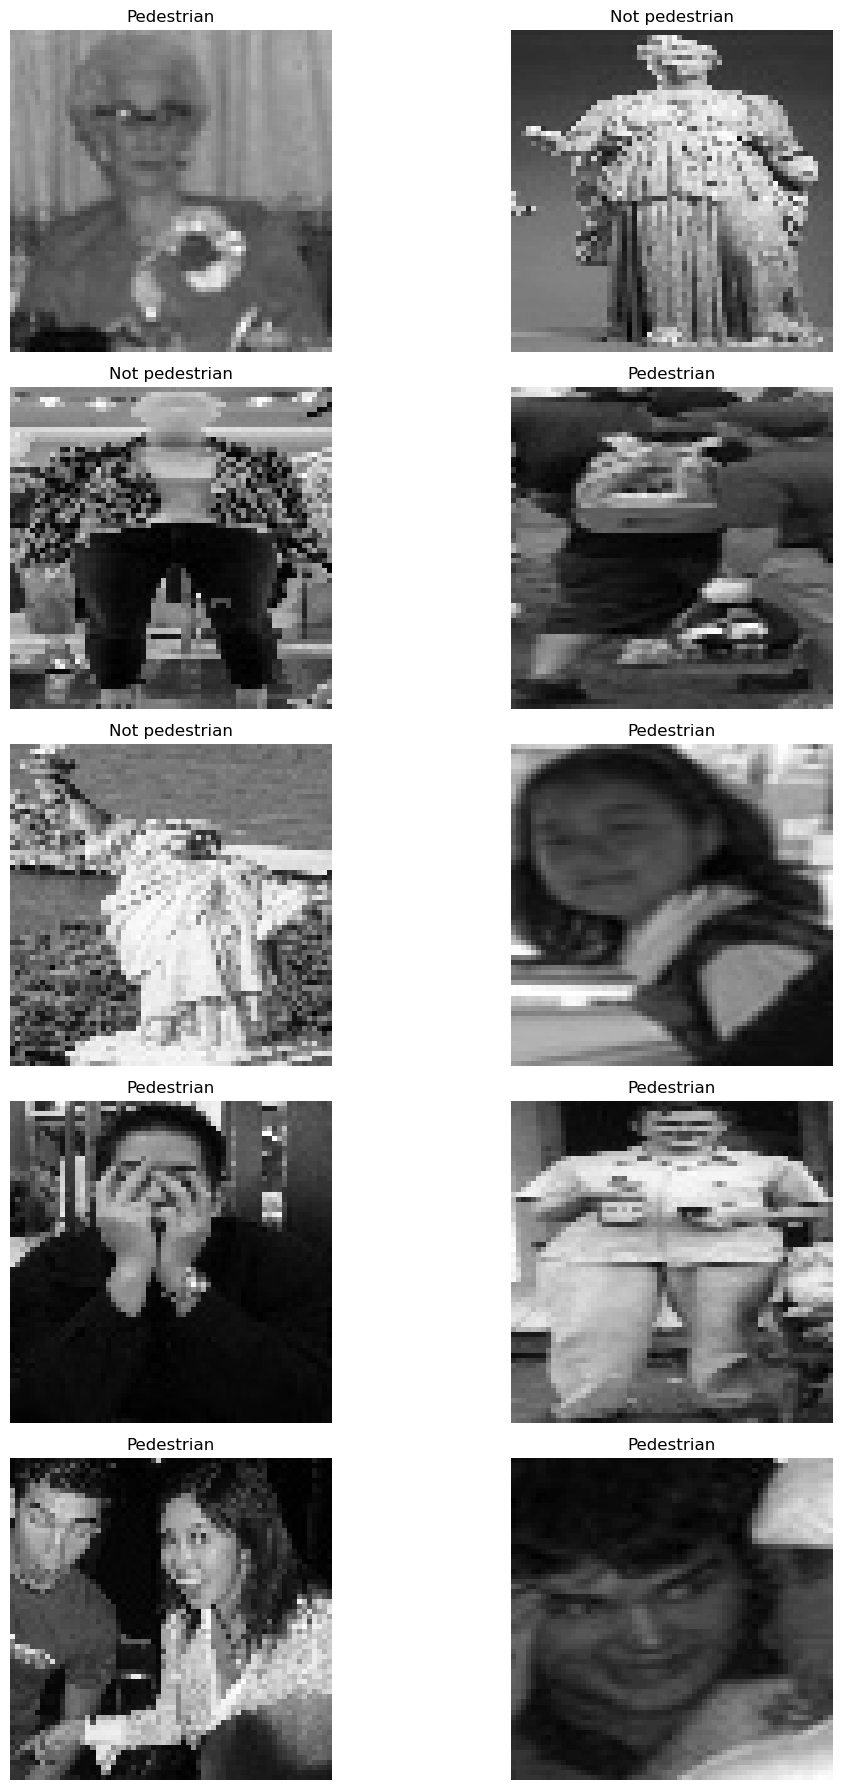

In [11]:
# convert all the images sample from BGR TO GRAY SCALE 
imgs_gray = utils.convert_BGR2GRAY(color_images=tmp_pedestrian_imgs)
# with utils plot_images method, plot the images gotten in sample dataset
utils.plot_images(images=imgs_gray, labels=tmp_pedestrian_labels, nrows=nrows, ncols=ncols, figsize=figsize)

In [12]:
# Initialize an empty list to store HOG features and corresponding HOG images
hog_features = []

# Iterate over a list of grayscale images (sample)
for gray_img in imgs_gray:
    # Extract HOG features and the HOG visualization image
    features,hog_img = utils.extract_hog(gray_img)
    
    # Append the features and the HOG image to the list as a dictionary
    hog_features.append({
        "features": features, # HOG descriptor vector
        "hog_img": hog_img # HOG visualization image
    })


In [13]:
# Initialize an empty list to store the HOG visualization images
hog_imgs = []

# Iterate over the list of extracted HOG features with their index
for idx, hog_feature in enumerate(hog_features, 0):
    # Append the HOG visualization image to the list
    hog_imgs.append(hog_feature["hog_img"])
    
    # Print the index, shape of the HOG feature vector, and the shape of the HOG image
    print(f"IMAGE_{idx}.- FEATURE SHAPE -> {hog_feature['features'].shape} [*] IMG SHAPE -> {hog_feature['hog_img'].shape}")

IMAGE_0.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_1.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_2.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_3.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_4.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_5.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_6.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_7.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_8.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)
IMAGE_9.- FEATURE SHAPE -> (396,) [*] IMG SHAPE -> (64, 64)


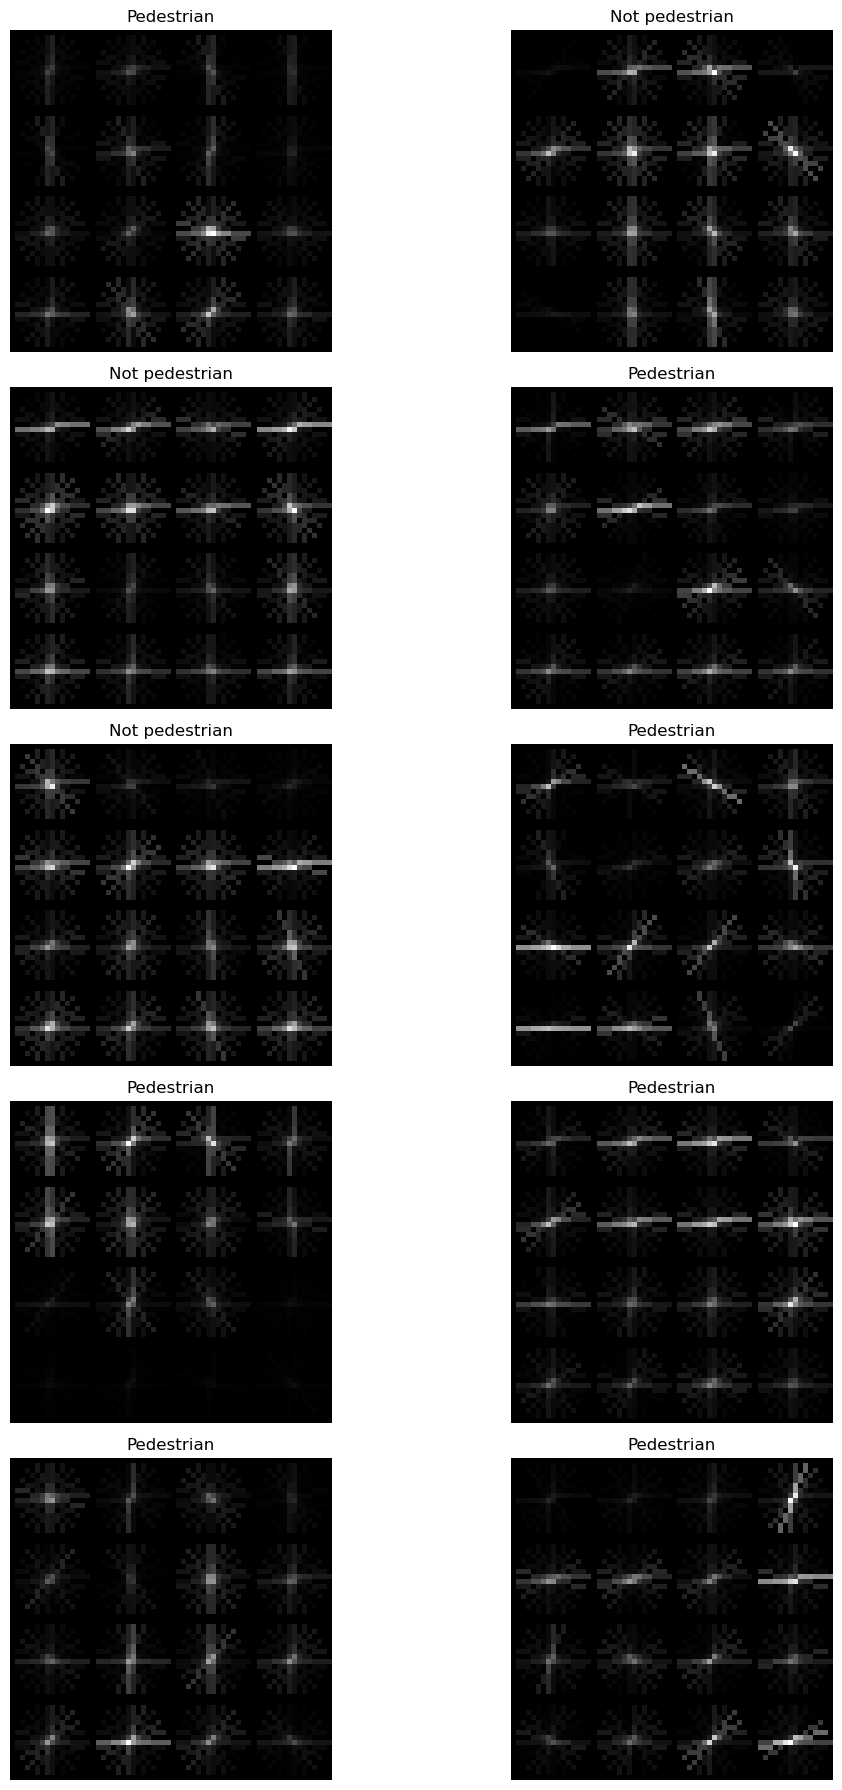

In [14]:
# display the HOG visualization images in a grid format
utils.plot_images(images=hog_imgs, labels=tmp_pedestrian_labels, nrows=nrows, ncols=ncols, figsize=figsize)

# Extract HOG features from the pedestrian dataset

In [15]:
# Extract HOG features
utils.process_hog_imgs(pedestrians_df)

100%|██████████| 2066/2066 [00:09<00:00, 225.30it/s]


In [16]:
# Load the preprocessed dataset containing HOG features using pandas' pickle loader
df = pd.read_pickle(utils.pickle_file)
# Display the first 5 rows of the dataframe
df.head()

,filename,label,features
0,/Users/alejandrocalderon/Documents/MIA/self_dr...,1,"[0.17621226757272837, 0.11970332756318078, 0.2..."
1,/Users/alejandrocalderon/Documents/MIA/self_dr...,1,"[0.17434682525850692, 0.16302948567861925, 0.1..."
2,/Users/alejandrocalderon/Documents/MIA/self_dr...,1,"[0.14285142494707212, 0.038435981037694036, 0...."
3,/Users/alejandrocalderon/Documents/MIA/self_dr...,1,"[0.09548145701380828, 0.025004826031810708, 0...."
4,/Users/alejandrocalderon/Documents/MIA/self_dr...,1,"[0.2433784390606614, 0.010232653819074329, 0.0..."


In [18]:
# Extract the list of HOG feature vectors from the 'features' column
X = df["features"].tolist()
# Extract the list of labels from the 'label' column and convert it to a NumPy array
y = np.array(df["label"].tolist())
# Stack the list of feature vectors into a single NumPy array (2D matrix)
# and ensure the data type is float64 for numerical processing
X = np.vstack(X).astype(np.float64)
# Extract the list of image file paths or identifiers from the 'filename' column
image_ids = df["filename"].tolist()

In [19]:
# Print the shape of the feature matrix (number of samples, number of features)
print(X.shape)
# Print the shape of the label array (number of labels)
print(y.shape)
# Print the total number of image identifiers (should match number of samples)
print(len(image_ids))

(2066, 396)
(2066,)
2066


# Generate the training and testing data

In [20]:
#Split the dataset into training and testing sets
# 70% of the data will be used for training, and 30% for testing
# The split is done in a stratified and reproducible way using random_state=42
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, # HOG feature vectors
    y, # Labels
    image_ids, # Image identifiers
    test_size = 0.3, # 30% of the data for testing
    random_state = 42 # Ensures reproducibility
)

In [21]:
# Display the shape of the training feature matrix
X_train.shape

(1446, 396)

In [22]:
# Display the shape of the testing feature matrix
X_test.shape

(620, 396)

In [23]:
# Display the first 5 image paths from the training set
id_train[:5]

['/Users/alejandrocalderon/Documents/MIA/self_driving_car/data/pedestrians/processed/train/img/image (736)_4.jpg',
 '/Users/alejandrocalderon/Documents/MIA/self_driving_car/data/pedestrians/processed/train/img/image (485)_1.jpg',
 '/Users/alejandrocalderon/Documents/MIA/self_driving_car/data/pedestrians/processed/train/img/image (519)_1.jpg',
 '/Users/alejandrocalderon/Documents/MIA/self_driving_car/data/pedestrians/processed/train/img/image (225)_1.jpg',
 '/Users/alejandrocalderon/Documents/MIA/self_driving_car/data/pedestrians/processed/train/img/image (50)_0.jpg']

In [24]:
# Display the first 5 image paths from the testing set
id_test[:5]

['/Users/alejandrocalderon/Documents/MIA/self_driving_car/data/pedestrians/processed/train/img/image (710)_0.jpg',
 '/Users/alejandrocalderon/Documents/MIA/self_driving_car/data/pedestrians/processed/train/img/image (915)_2.jpg',
 '/Users/alejandrocalderon/Documents/MIA/self_driving_car/data/pedestrians/processed/train/img/image (647)_0.jpg',
 '/Users/alejandrocalderon/Documents/MIA/self_driving_car/data/pedestrians/processed/train/img/image (846)_1.jpg',
 '/Users/alejandrocalderon/Documents/MIA/self_driving_car/data/pedestrians/processed/train/img/image (113)_0.jpg']

# Se importa el Clasificador y se entrena

In [25]:

#svc_model = LinearSVC()
#svc_model.fit(X_train, y_train)

# Create an instance of a Support Vector Classifier (SVC)
svc_model = SVC()
# Train the SVC model using the training feature vectors and their corresponding labels
svc_model.fit(X_train,y_train)

SVC()

In [26]:
# Use the trained SVC model to make predictions on the test feature set
y_predict = svc_model.predict(X_test)

<Axes: >

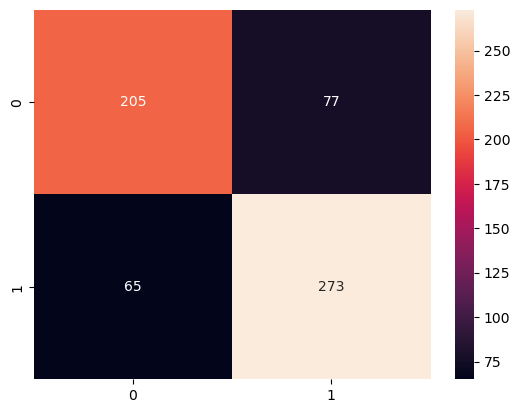

In [27]:
# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_test,y_predict)
# Plot the confusion matrix as a heatmap using seaborn
# 'annot=True' displays the counts in each cell
# 'fmt="d"' formats the annotations as integers
sns.heatmap(cm, annot=True, fmt = "d")

For our classification we care to know if it is a pedestrian (label **1**) to minimize missing actual pedestrians, **important for safety** 
Where  
* With precission: 78% of the time the model says is pedestrian
* With Recall: of all true pedestrians, the model correctly detects 81% of them
* With F1-score: the model is a bit better at detecting pedestrians than non-pedestrians.

In [28]:
# Print a detailed classification report including precision, recall, f1-score, and support for each class
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74       282
           1       0.78      0.81      0.79       338

    accuracy                           0.77       620
   macro avg       0.77      0.77      0.77       620
weighted avg       0.77      0.77      0.77       620



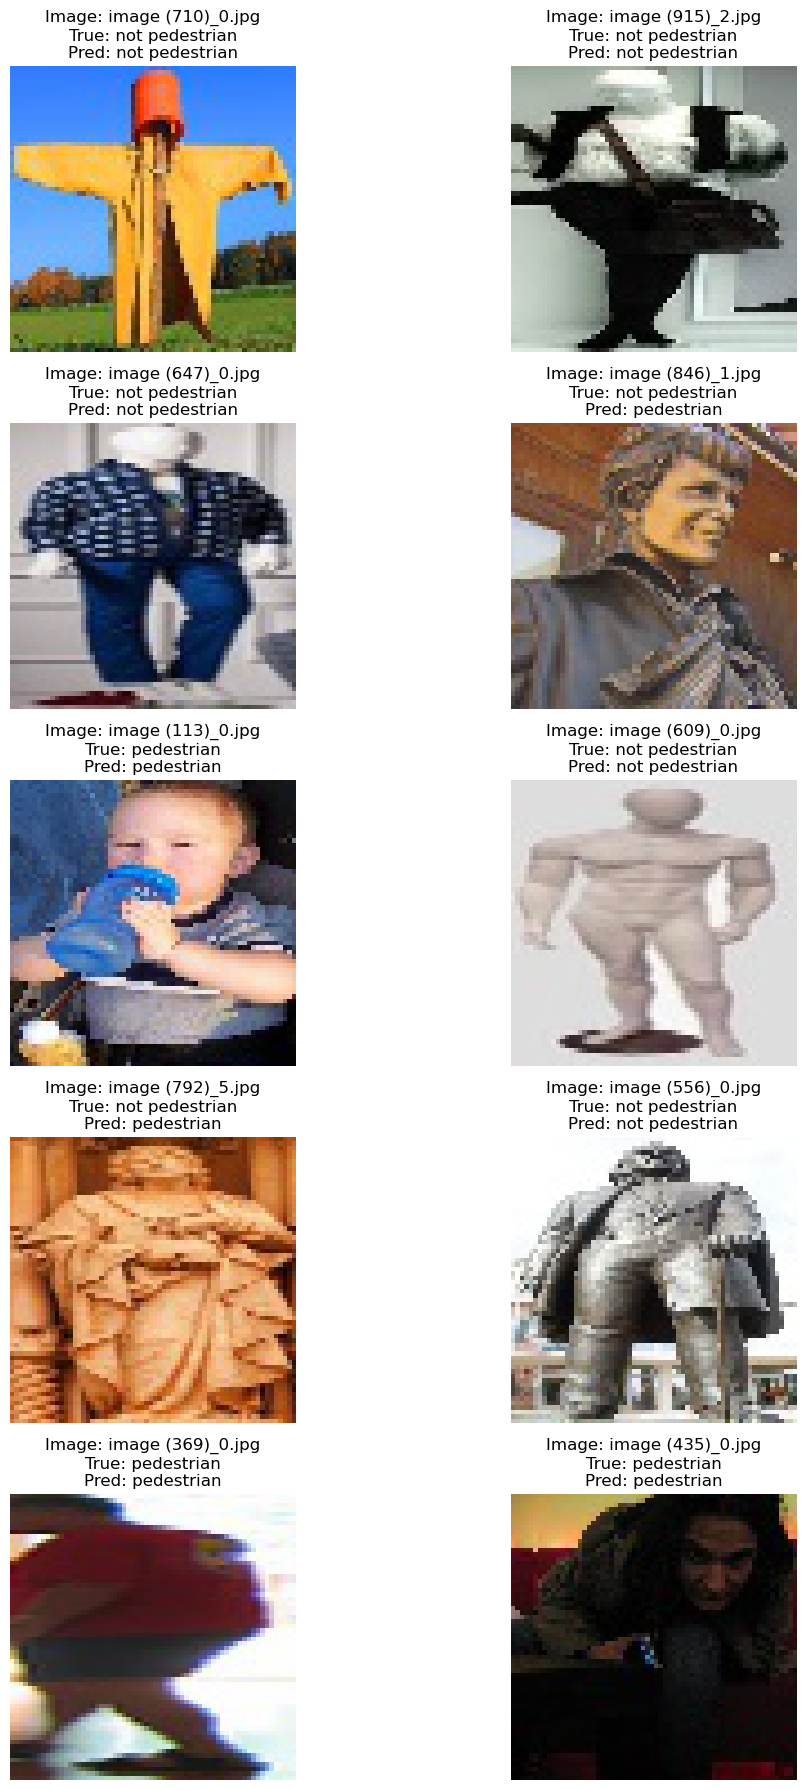

In [29]:
# Use a function to visually display prediction results
utils.show_predictions(image_ids=id_test, y_true= y_test, y_pred=y_predict, nrows=nrows, ncols=ncols, figsize=figsize)

# GridSearchCV

In [30]:
# Define a grid of hyperparameters to search over for tuning the SVC model using GridSearchCV
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [31]:
# Create a GridSearchCV object to perform exhaustive search over the hyperparameter grid
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=4)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.528 total time=   0.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.529 total time=   0.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.529 total time=   0.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.533 total time=   0.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.533 total time=   0.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.648 total time=   0.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.654 total time=   0.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.647 total time=   0.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.661 total time=   0.2s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.664 total time=   0.2s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.531 total time=   0.2s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=4)

In [32]:
# Retrieve the best combination of hyperparameters (C, gamma, kernel)
grid.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [33]:
grid.best_estimator_

SVC(C=10, gamma=1)

In [34]:
# Use the best-found SVC model
grid_predictions = grid.predict(X_test)

<Axes: >

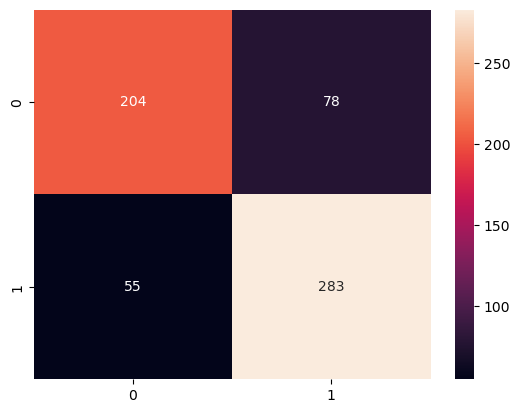

In [35]:
# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_test,grid_predictions)
# Plot the confusion matrix as a heatmap using seaborn
# 'annot=True' displays the counts in each cell
# 'fmt="d"' formats the annotations as integers
sns.heatmap(cm, annot=True, fmt = "d")

For our classification we care to know if it is a pedestrian (label **1**) to minimize missing actual pedestrians, **important for safety** 
Where  
* With precission: 78% of the time the model says is pedestrian
* With Recall: of all true pedestrians, the model correctly detects 84% of them
* With F1-score: the model is a bit better at detecting pedestrians than non-pedestrians.

In [36]:
# Print a detailed classification report including precision, recall, f1-score, and support for each class
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.79      0.72      0.75       282
           1       0.78      0.84      0.81       338

    accuracy                           0.79       620
   macro avg       0.79      0.78      0.78       620
weighted avg       0.79      0.79      0.78       620



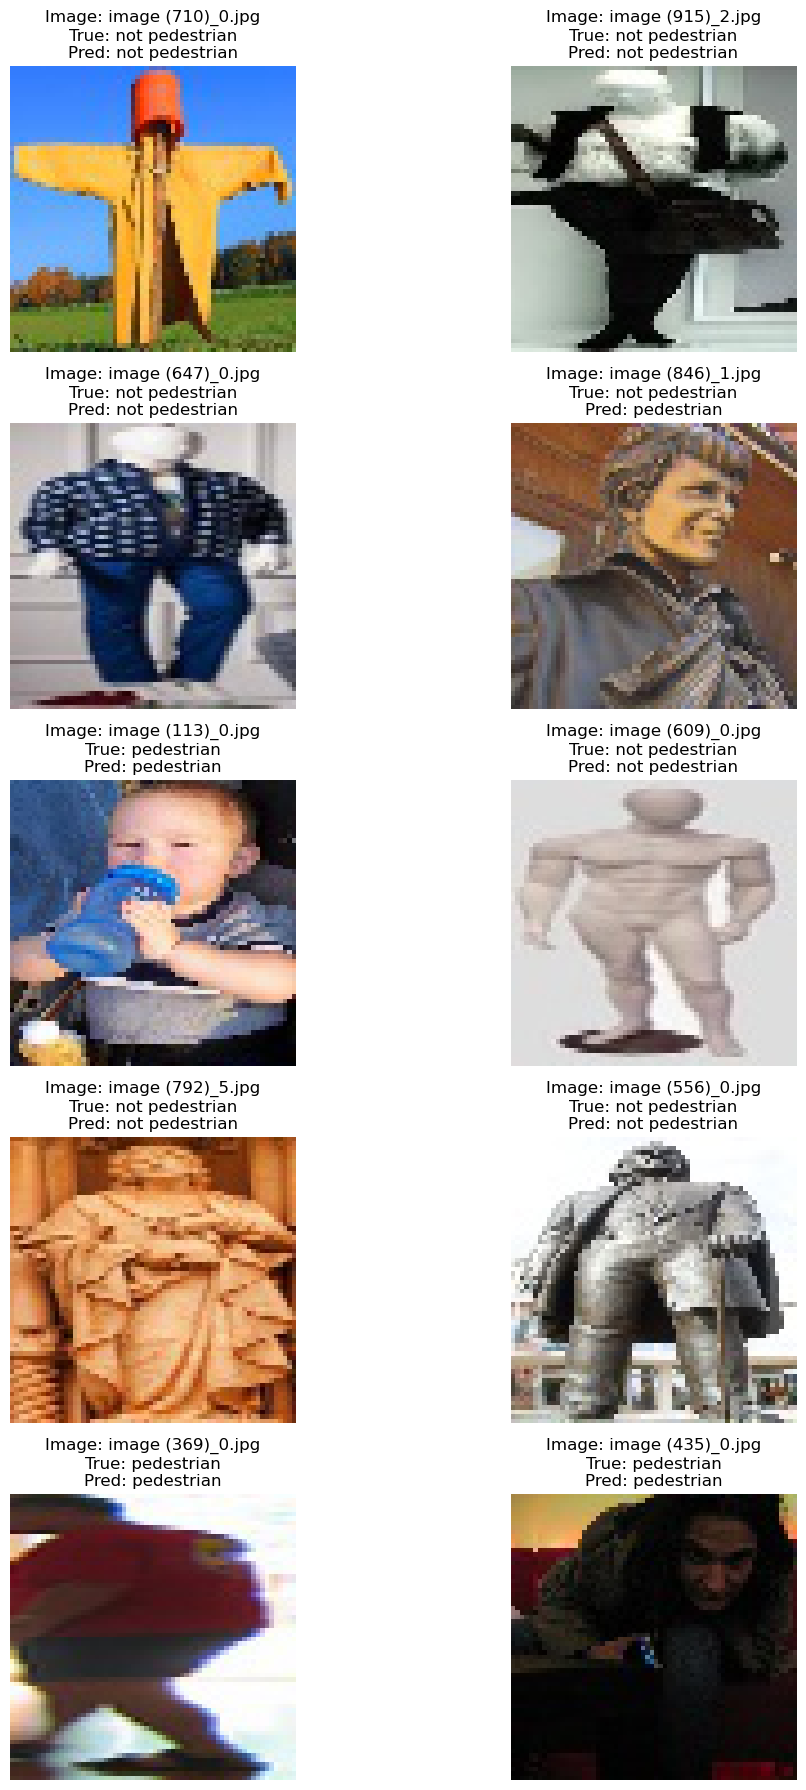

In [37]:
# Use a function to visually display prediction results
utils.show_predictions(image_ids=id_test, y_true= y_test, y_pred=grid_predictions, nrows=nrows, ncols=ncols, figsize=figsize)

In [38]:
linear_svc_model = LinearSVC()
linear_svc_model.fit(X_train, y_train)


/Users/alejandrocalderon/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [39]:
y_linearsvc_predict = svc_model.predict(X_test)

<Axes: >

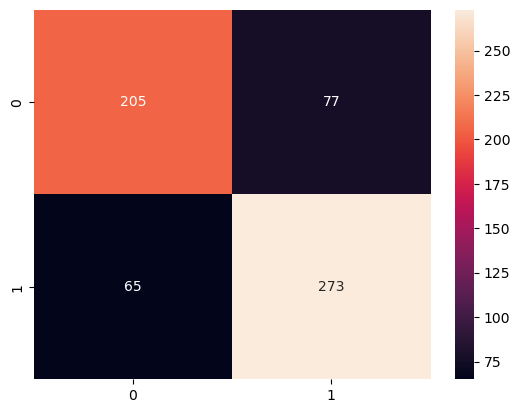

In [40]:
# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_test,y_linearsvc_predict)
# Plot the confusion matrix as a heatmap using seaborn
# 'annot=True' displays the counts in each cell
# 'fmt="d"' formats the annotations as integers
sns.heatmap(cm, annot=True, fmt = "d")

In [41]:
# Print a detailed classification report including precision, recall, f1-score, and support for each class
print(classification_report(y_test,y_linearsvc_predict))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74       282
           1       0.78      0.81      0.79       338

    accuracy                           0.77       620
   macro avg       0.77      0.77      0.77       620
weighted avg       0.77      0.77      0.77       620



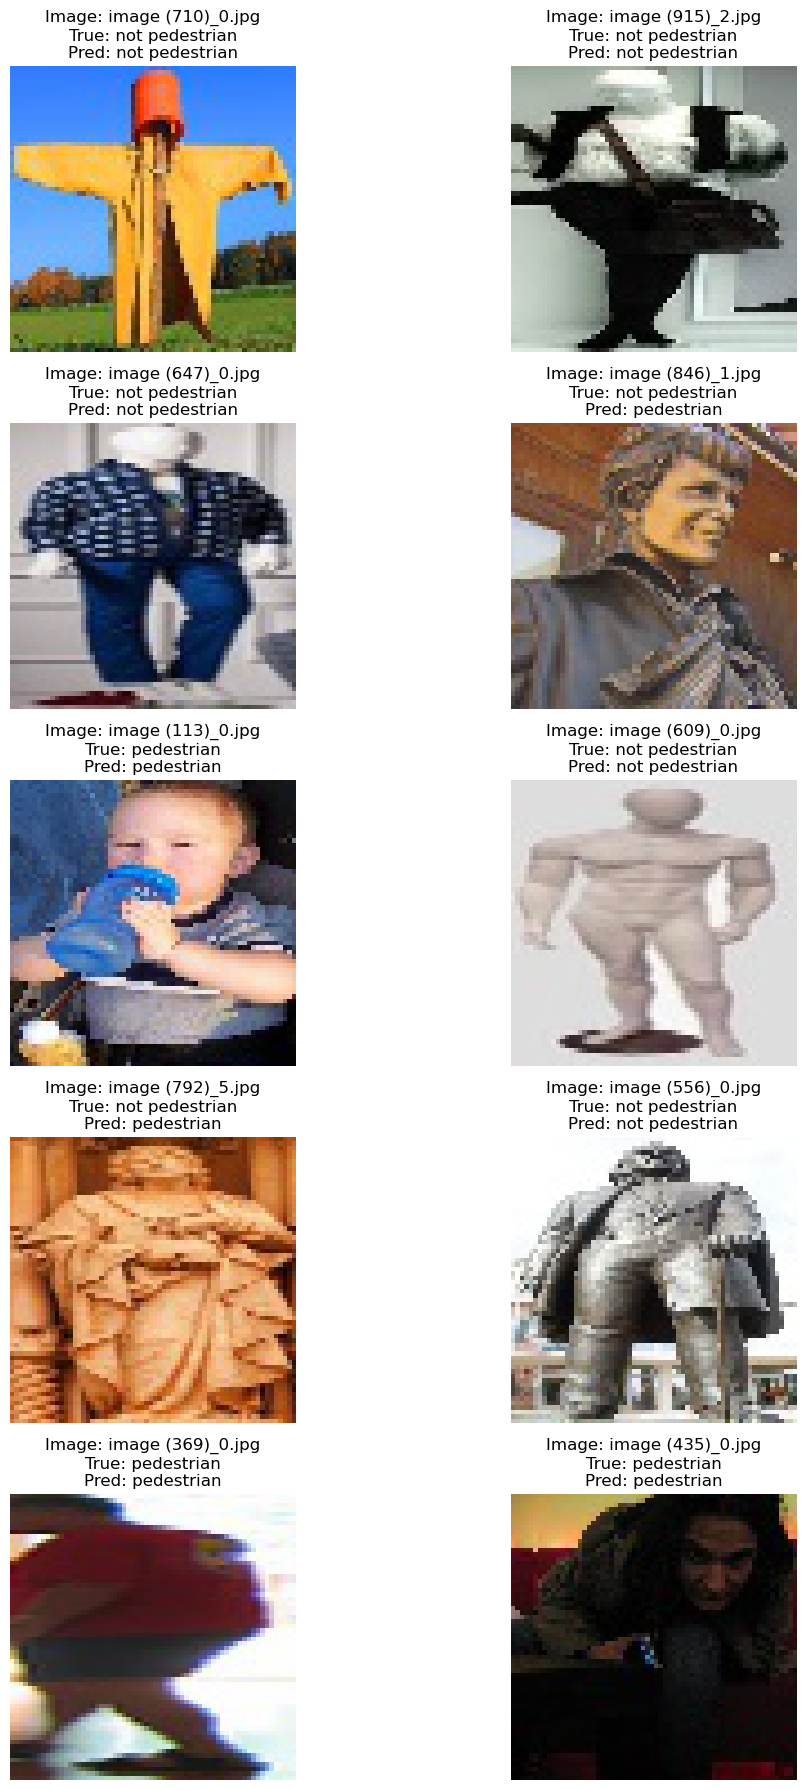

In [42]:
utils.show_predictions(image_ids=id_test, y_true= y_test, y_pred=y_linearsvc_predict, nrows=nrows, ncols=ncols, figsize=figsize)